Deep Learning Exercise
---
Jonathan Schwartz & Jonathan Schory

MCTS

In [0]:
import math
import numpy as np
EPS = 1e-8

class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.Qsa = {}       # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}       # stores #times edge s,a was visited
        self.Ns = {}        # stores #times board s was visited
        self.Ps = {}        # stores initial policy (returned by neural net)

        self.Es = {}        # stores game.getGameEnded ended for board s
        self.Vs = {}        # stores game.getValidMoves for board s
        
        self.plot = [1000]
        self.num_sim = [0]

    def getActionProb(self, graphState, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for i in range(self.args.numMCTSSims):
            self.search(graphState, i)

        s = self.game.stringRepresentation(graphState)
        counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in range(self.game.getActionSize())]

        if temp==0:
            bestA = np.argmax(counts)
            probs = [0]*len(counts)
            probs[bestA]=1
            return probs

        counts = [x**(1./temp) for x in counts]
        counts_sum = float(sum(counts))
        probs = [x/counts_sum for x in counts]
        return probs


    def search(self, graphState, num_sim):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = self.game.stringRepresentation(graphState)

        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(graphState)
        if self.Es[s]!=0:
            # terminal node
            return 0

        if s not in self.Ps:
            # leaf node
            if self.nnet is not None:
                self.Ps[s], v = self.nnet.predict(graphState, self.game.graph)
            else:
                self.Ps[s] = np.ones(self.game.getActionSize()) # random policy
                v = 0
            valids = self.game.getValidMoves(graphState)
            self.Ps[s] = self.Ps[s]*valids      # masking invalid moves
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s    # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable
                
                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.   
                print("All valid moves were masked, do workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return v

        valids = self.Vs[s]
        cur_best = -float('inf')
        best_act = -1

        # pick the action with the highest upper confidence bound
        for a in range(self.game.getActionSize()):
            if valids[a]:
                if (s,a) in self.Qsa:
                    u = self.Qsa[(s,a)] + self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s])/(1+self.Nsa[(s,a)])
                else:
                    u = self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s] + EPS)     # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a

        a = best_act
        next_s, reward = self.game.getNextState(graphState, a)
        # next_s = self.game.getCanonicalForm(next_s, next_player)

        v = self.search(next_s, num_sim) + reward

        if (s,a) in self.Qsa:
            self.Qsa[(s,a)] = (self.Nsa[(s,a)]*self.Qsa[(s,a)] + v)/(self.Nsa[(s,a)]+1)
            self.Nsa[(s,a)] += 1

        else:
            self.Qsa[(s,a)] = v
            self.Nsa[(s,a)] = 1
            
        if v > self.game.getActionSize() - self.plot[-1]:
            self.plot.append(self.game.getActionSize() - v)
            self.num_sim.append(num_sim)

        self.Ns[s] += 1
        return v

TSP Game

In [0]:
from itertools import permutations 

class TSPGame():

    def __init__(self, num_node):
        self.num_node = num_node # number of nodes in the graph
        self.graph = np.random.rand(self.num_node, 2) # each index representing xy coordinates 

    def getInitState(self):
        """
        Returns:
            first_state: a representation of the graph
            left column representing visited nodes
            right column will always have a single 1 and the rest are 0's. index with the 1 in the right column is current node
        """
        first_state = np.zeros([self.num_node, 2])
        # Always start with first node as current node 
        first_state[0][0] = 1
        first_state[0][1] = 1
        return first_state

    def getBoardSize(self):
        """
        Returns:
            (x,y): a tuple of board dimensions
        """
        pass

    def getActionSize(self):
        """
        Returns:
            actionSize: number of all possible actions
        """
        return self.num_node
    
    def getNextState(self, state, action):
        """
        Input:
            state: current state
            action: action taken by current player
        Returns:
            next_s: graph after applying action
            reward: reward from action
        """
        
        next_s = state.copy()
        # zero out current node
        for n in next_s:
          if n[1] == 1:
            prev_action = np.where(next_s == n)[0][0]
            n[1] = 0
        # 1 in left column for visited, 1 in right column for current node
        next_s[action] = 1
        
        # get xy coordinates for prev_node and current_node from the graph
        prev_node = self.graph[prev_action]
        current_node = self.graph[action]
          
        reward = 1 - np.linalg.norm(current_node - prev_node)
        if self.getCountVisitedNodes(next_s) == self.num_node: #end of game
            reward += 1 - np.linalg.norm(current_node - self.graph[0])
            
        return next_s, reward

    def getValidMoves(self, state):
        """
        Input:
            state: current state
        Returns:
            list of valid moves, 1 for valid, 0 for invalid 
        """
        return 1 - state[:, 0]

    def getCountVisitedNodes(self, state):
      count_visited = 0
      for n in state:
        if n[0] == 1:
          count_visited += 1
      
      return count_visited
    
    def getGameEnded(self, state):
        """
        Input:
            state: current state
        Returns:
            r: 0 if game has not ended. 1 if it has
               
        """
        end = 0
        if self.getCountVisitedNodes(state) == self.num_node:
            end = 1
        return end

    def getCanonicalForm(self, board, player):
        """
        Input:
            board: current board
            player: current player (1 or -1)
        Returns:
            canonicalBoard: returns canonical form of board. The canonical form
                            should be independent of player. For e.g. in chess,
                            the canonical form can be chosen to be from the pov
                            of white. When the player is white, we can return
                            board as is. When the player is black, we can invert
                            the colors and return the board.
        """
        pass

    def getSymmetries(self, board, pi):
        """
        Input:
            board: current board
            pi: policy vector of size self.getActionSize()
        Returns:
            symmForms: a list of [(board,pi)] where each tuple is a symmetrical
                       form of the board and the corresponding pi vector. This
                       is used when training the neural network from examples.
        """
        pass

    def stringRepresentation(self, state):
        """
        Input:
            state: current state
        Returns:
            index of state
        """
        s = ''
        for i in range(self.num_node):
            s += str(int(state[i][0]))
        return s
    
    def optimal(self):
        seq = np.arange(self.num_node)[1:]
        perm = permutations(seq)
        graph = self.graph
        reward = 0
        optimal = 10000
        action = []
        for p in list(perm):
            reward = 0
            reward += np.linalg.norm(graph[0] - graph[p[0]])
            reward += np.linalg.norm(graph[p[-1]] - graph[0])
            
            for k in range(len(p) - 1):
                i = p[k]
                j = p[k+1]
                reward += np.linalg.norm(graph[j] - graph[i])
            
            if reward < optimal:
                optimal = reward
                action = p
        
        return optimal, action

Part 1

In [0]:
class MCTS_args(object):
    def __init__(self, num_sim, cpuct):
        self.numMCTSSims = num_sim
        self.cpuct = cpuct

In [0]:
def play_TSP_MCTS(num_node, args):
    game = TSPGame(num_node)
    mcts = MCTS(game, None, args)
    state = game.getInitState()
    r = 0
    actions = []
    optimal_val, optimal_path = game.optimal()
    
    while not game.getGameEnded(state):
        action = np.argmax(mcts.getActionProb(state))
        state, reward = game.getNextState(state, action)
        actions.append(action)
        r += reward
    
    return mcts.plot, mcts.num_sim, optimal_val

In [1]:
optimal_list = []
mcts_dict = {}
num_node = 10
args = MCTS_args(num_sim = 20000, cpuct = 1)
for i in range(100):
  vals, num_s, optimalReward = play_TSP_MCTS(num_node, args)
  optimal_list.append(optimalReward)
  mcts_dict[i] = {tuple(num_s): vals}

print(optimal_list)
print(mcts_dict)


NameError: ignored

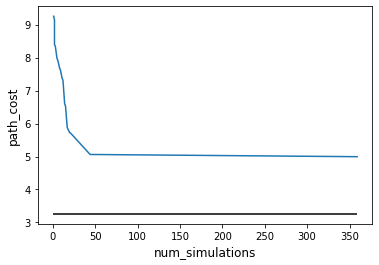

In [29]:
import matplotlib.pyplot as plt

plt.plot(np.array(num_s[1:]), vals[1:])
plt.xlabel("num_simulations", fontsize=12)
plt.ylabel("path_cost", fontsize=12)
plt.hlines(optimalReward, 0, num_s[-1])

In [0]:
import pandas as pd
columns = list(range(100))
df = pd.DataFrame(columns=columns)
i = 0
for result in mcts_dict:
  sims = list(mcts_dict[result].keys())[0]
  vals = list(mcts_dict[result].values())[0]
  col = np.zeros(20000)
  j = 0
  for sim in sims:
    col[sim] = vals[j]
    j += 1
  df[i] = col
  i += 1

In [33]:
for col in df:
  df[col] = df[col].replace(0.0, pd.np.nan)
  df[col] = df[col].ffill()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [0]:
df.drop(df.head(1).index, inplace=True)

In [0]:
opt_val_row = pd.DataFrame([pd.Series(optimal_list)], index=["opt"], dtype=float)
df = pd.concat([opt_val_row, df])
df.to_csv("100-games.csv")

In [0]:
opt_vals = df[0:1]
opt_vals = opt_vals.iloc[0]
df.drop(df.head(1).index, inplace=True)

In [37]:
df = df.reset_index(drop=True)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,9.480523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.021568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.442377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.495787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.698695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,3.075367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19995,3.075367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19996,3.075367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19997,3.075367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
within_factor = []
for i in range(19999):
  row = list(df.iloc[i])
  counter = 0
  for j in range(len(row)):
    if row[j] / opt_vals[j] <= 1.1:
      counter += 1
  within_factor += [counter / 100]

(-0.05500000000000001, 0.05)

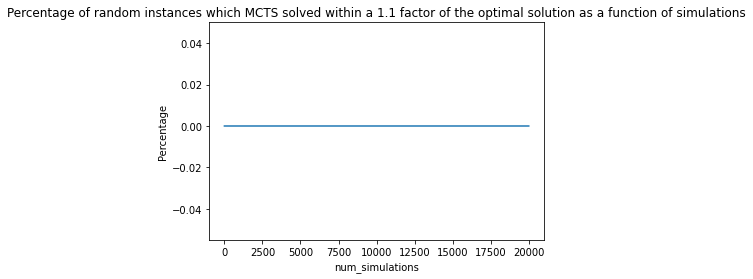

In [25]:
import matplotlib.pyplot as plt

plt.plot(np.array(range(19999)), within_factor)
plt.title("Percentage of random instances which MCTS solved within a 1.1 factor of the optimal solution as a function of simulations")
plt.xlabel("num_simulations")
plt.ylabel("Percentage")
plt.ylim(top=within_factor[-1] + 0.05)

**CNN**

Network Arguments 

In [0]:
class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

args = dotdict({
    # MCTS args
    'numMCTSSims': 20000,          # Number of games moves for MCTS to simulate.
    'num_node': 10,                 # Number of nodes in the graph (game)
    
    # Train args
    'numIters': 10,              # Number of episods to play (5 times 10 episodes)
    'numEps': 20,              # Number of complete self-play games to simulate during a new iteration.
    'tempThreshold': 15,        #
    'updateThreshold': 0.6,     # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': 200000,    # Number of game examples to train the neural networks.
    'arenaCompare': 40,         # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1,
    'numItersForTrainExamplesHistory': 25,
    
    # NN args
    'lr': 0.001,
    'dropout': 0.3,
    'epochs': 15,
    'batch_size': 64,
    'cuda': False,
    'num_channels': 512,
    })

Create Training Examples

In [39]:
game = TSPGame(args.num_node)
net = NNet(game, args)
data = []
for i in range(2):
    coach = Coach2(game, net, args)
    data.append(coach.learn())
    game = TSPGame(args.num_node)

------ITER 1------


KeyboardInterrupt: ignored

Train the model

In [36]:
net = NNet(t2, args)
examples = []
for example in data:
    for e in example:
        examples.append(e)
n2.train(examples)

Training...
Epoch 1/15
7/7 [==============================] - 0s 10ms/step - loss: 0.9283 - pi_loss: 0.7930 - v_loss: 0.1352
Epoch 2/15
7/7 [==============================] - 0s 9ms/step - loss: 0.7254 - pi_loss: 0.5750 - v_loss: 0.1503
Epoch 3/15
7/7 [==============================] - 0s 9ms/step - loss: 0.6487 - pi_loss: 0.5030 - v_loss: 0.1457
Epoch 4/15
7/7 [==============================] - 0s 9ms/step - loss: 0.5941 - pi_loss: 0.4610 - v_loss: 0.1332
Epoch 5/15
7/7 [==============================] - 0s 9ms/step - loss: 0.6008 - pi_loss: 0.4754 - v_loss: 0.1254
Epoch 6/15
7/7 [==============================] - 0s 10ms/step - loss: 0.5821 - pi_loss: 0.4556 - v_loss: 0.1264
Epoch 7/15
7/7 [==============================] - 0s 9ms/step - loss: 0.5406 - pi_loss: 0.4202 - v_loss: 0.1204
Epoch 8/15
7/7 [==============================] - 0s 9ms/step - loss: 0.5174 - pi_loss: 0.4034 - v_loss: 0.1140
Epoch 9/15
7/7 [==============================] - 0s 9ms/step - loss: 0.5124 - pi_loss: 0.

In [0]:
class Coach2():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """
    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
#         self.pnet = self.nnet.__class__(self.game)  # the competitor network
        self.args = args
        self.mcts = MCTS(self.game, self.nnet, self.args)
        self.trainExamplesHistory = []    # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.skipFirstSelfPlay = False    # can be overriden in loadTrainExamples()

    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.

        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.

        Returns:
            trainExamples: a list of examples of the form (canonicalBoard,pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        trainExamples = []
        board = self.game.getInitState()
#         self.curPlayer = 1
        episodeStep = 0

        while True:
            episodeStep += 1
            temp = int(episodeStep < self.args.tempThreshold)

            pi = self.mcts.getActionProb(board, temp=temp)

            action = np.random.choice(len(pi), p=pi)
            next_board, reward = self.game.getNextState(board, action)
            trainExamples.append([board, self.game.graph, pi, reward])

            r = self.game.getGameEnded(next_board)
            
            if r!=0:
                return [tuple(x) for x in trainExamples]
            
            board = next_board

    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """
        for i in range(1, self.args.numIters+1):
            # bookkeeping
            print('------ITER ' + str(i) + '------')
            # examples of the iteration
            if not self.skipFirstSelfPlay or i>1:
                iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

                for eps in range(self.args.numEps):
                    self.mcts = MCTS(self.game, self.nnet, self.args)   # reset search tree
                    iterationTrainExamples += self.executeEpisode()

                self.trainExamplesHistory.append(iterationTrainExamples)
                
            if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
                print("len(trainExamplesHistory) =", len(self.trainExamplesHistory), " => remove the oldest trainExamples")
                self.trainExamplesHistory.pop(0)

            # shuffle examples before training
            trainExamples = []
            for e in self.trainExamplesHistory:
                trainExamples.extend(e)
            shuffle(trainExamples)
            
            # train
            # self.nnet.train(trainExamples)
        return trainExamples


In [0]:
from collections import deque
import time, os, sys
from pickle import Pickler, Unpickler
from random import shuffle


class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """
    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
#         self.pnet = self.nnet.__class__(self.game)  # the competitor network
        self.args = args
        self.mcts = MCTS(self.game, self.nnet, self.args)
        self.trainExamplesHistory = []    # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.skipFirstSelfPlay = False    # can be overriden in loadTrainExamples()

    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.

        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.

        Returns:
            trainExamples: a list of examples of the form (canonicalBoard,pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        trainExamples = []
        board = self.game.getInitState()
#         self.curPlayer = 1
        episodeStep = 0

        while True:
            episodeStep += 1
            temp = int(episodeStep < self.args.tempThreshold)

            pi = self.mcts.getActionProb(board, temp=temp)

            action = np.random.choice(len(pi), p=pi)
            next_board, reward = self.game.getNextState(board, action)
            trainExamples.append([board, pi, reward])

            r = self.game.getGameEnded(next_board)
            
            if r!=0:
                return [tuple(x) for x in trainExamples]
            
            board = next_board

    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """
        for i in range(1, self.args.numIters+1):
            # bookkeeping
            print('------ITER ' + str(i) + '------')
            # examples of the iteration
            if not self.skipFirstSelfPlay or i>1:
                iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

                for eps in range(self.args.numEps):
                    self.mcts = MCTS(self.game, self.nnet, self.args)   # reset search tree
                    iterationTrainExamples += self.executeEpisode()

                self.trainExamplesHistory.append(iterationTrainExamples)
                
            if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
                print("len(trainExamplesHistory) =", len(self.trainExamplesHistory), " => remove the oldest trainExamples")
                self.trainExamplesHistory.pop(0)

            # shuffle examples before training
            trainExamples = []
            for e in self.trainExamplesHistory:
                trainExamples.extend(e)
            shuffle(trainExamples)
            
            # train
            self.nnet.train(trainExamples)


In [0]:
import sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [0]:
class NNet():
    def __init__(self, game, args):
        self.b = game.num_node
        self.action_size = game.getActionSize()
        
        self.create_net(game)

    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        print("Training...")
        input_boards, input_graphs, target_pis, target_vs = list(zip(*examples))
        input_boards = np.asarray(input_boards)
        input_graphs = np.asarray(input_graphs)
        target_pis = np.asarray(target_pis)
        target_vs = np.asarray(target_vs)
        self.model.fit(x = [input_boards, input_graphs], y = [target_pis, target_vs], batch_size = args.batch_size, epochs = args.epochs)

    def predict(self, board, graph):
        """
        board: np array with board
        """
        # preparing input
        board = board[np.newaxis, :, :]
        graph = graph[np.newaxis, :, :]

        # run
        pi, v = self.model.predict([board, graph])

        #print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
        return pi[0], v[0]
    
    def create_net(self, game):
        # Neural Net
        self.input_boards = Input(shape=game.getInitState().shape)    # s: batch_size x board_x x board_y

        x_image = Reshape((args['num_node'], 2, 1))(self.input_boards)                # batch_size  x board_x x board_y x 1
        h_conv1 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(x_image)))         # batch_size  x board_x x board_y x num_channels
        h_conv2 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(h_conv1)))         # batch_size  x board_x x board_y x num_channels
        h_conv3 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(h_conv2)))        # batch_size  x (board_x) x (board_y) x num_channels
        h_conv4 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='valid')(h_conv3)))        # batch_size  x (board_x-2) x (board_y-2) x num_channels
        h_conv4_flat = Flatten()(h_conv4)       
        s_fc1 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(1024)(h_conv4_flat))))  # batch_size x 1024
        s_fc2 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(512)(s_fc1))))          # batch_size x 1024
        self.pi = Dense(self.action_size, activation='softmax', name='pi')(s_fc2)   # batch_size x self.action_size
        self.v = Dense(1, activation='tanh', name='v')(s_fc2)                    # batch_size x 1

        self.model = Model(inputs=self.input_boards, outputs=[self.pi, self.v])
        self.model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=Adam(args.lr))

In [0]:
# t = TSPGame(args.num_node)
# n = NNet(t, args)
# c = Coach(t, n, args)
# c.learn()

MCTS with trained net

In [0]:
mcts = MCTS(t, n, args)
state = t.getInitState()
mcts_reward = 0
mcts_actions = []
optimal_val, optimal_path = t.optimal()

while not t.getGameEnded(state):
    p = mcts.getActionProb(state)
    print(p)
    action = np.argmax(p)
    state, reward = t.getNextState(state, action)
    mcts_actions.append(action)
    mcts_reward += reward

print('Optimal Solution:', optimal_val)
print('Optimal Action:', optimal_path)
print('MCTS Reward:', t.getActionSize() - mcts_reward)
print('MCTS Action:', mcts_actions)

mcts.plot, mcts.num_sim, optimal_val